# TRANSFORMER MODEL

In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

from tensorflow.keras.models import *

import warnings
warnings.filterwarnings('ignore')

In [42]:
df_raw = pd.read_csv("Bitcoin_data.csv")
df_raw = df_raw.drop(columns=['SNo','Name','Symbol'])
df_orig = pd.read_csv("Bitcoin_data.csv")

df_raw['Date'] = pd.to_datetime(df_raw['Date']).dt.date
df_orig['Date'] = pd.to_datetime(df_orig['Date']).dt.date

print(df_raw.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Marketcap  
0  8.955395e+09  
1  8.869919e+09  
2  9.082104e+09  
3  9.217168e+09  
4  9.191325e+09  


In [43]:
# helper functions

In [44]:
def getratio(data):
  ratios = []
  ratios.append(1)
  # data +=1e-20
  for i in range(1,len(data)):
    if data[i] ==0 or data[i-1] ==0:
      ratios.append(np.nan)
    else:
      ratios.append(data[i]/data[i-1])
  return ratios

def takeratio(df, col1, col2):
  temp = []
  for i in range(len(df)):
    temp.append(df.loc[i,col1]/df.loc[i,col2])
  return temp

In [45]:
def preprocess(dataf):
  df1 = dataf.copy()
  #Get the the total number of shares in the market using market cap and closing price 
  num_shares = list()
  for i in range(len(df1)):
    num_shares.append(df1.loc[i,'Marketcap']/df1.loc[i,'Close'])
  df1['Numshares'] = num_shares
  df1 = df1.drop(columns=['Marketcap'])


  #Create features

  # 1. ratio of x_[i] and x_[i-1] for each numeric column
  for col in df1.columns:
    if col == 'Date':
      continue
    df1[col+"_ratio"] = getratio(df1[col])
  # 2. ratio of High Low and Close Open
  df1["HighLowRatio"] = takeratio(df1,"High","Low")
  df1["CloseOpenRatio"] = takeratio(df1,"Close","Open")
  return df1

In [46]:
df = preprocess(df_raw)
print(df.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Numshares  High_ratio  Low_ratio  Open_ratio  Close_ratio  Volume_ratio  \
0  1.218305e+07    1.000000   1.000000    1.000000     1.000000      1.000000   
1  1.218680e+07    0.960837   0.988439    0.966854     0.990151      0.693639   
2  1.218993e+07    1.002075   1.012887    0.986544     1.023659      0.584859   
3  1.218992e+07    1.024031   1.036112    1.018268     1.014872      1.089231   
4  1.218992e+07    0.992147   0.997204    1.025588     0.997196      1.009156   

   Numshares_ratio  HighLowRatio  CloseOpenRatio  

In [47]:
df = df.assign(Close_ratio_cum = df['Close_ratio'])
col = df.pop('Close_ratio_cum')
df.insert(10, 'Close_ratio_cum', col)
df['Close_ratio_cum'] = df['Close_ratio_cum'].cumsum()

df = df.drop('Close_ratio', axis=1)

df = df.assign(Volume_ratio_cum = df['Volume_ratio'])
col = df.pop('Volume_ratio_cum')
df.insert(11, 'Volume_ratio_cum', col)
df['Volume_ratio_cum'] = df['Volume_ratio_cum'].cumsum()

df = df.drop('Volume_ratio', axis=1)

print(df.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Numshares  High_ratio  Low_ratio  Open_ratio  Close_ratio_cum  \
0  1.218305e+07    1.000000   1.000000    1.000000         1.000000   
1  1.218680e+07    0.960837   0.988439    0.966854         1.990151   
2  1.218993e+07    1.002075   1.012887    0.986544         3.013810   
3  1.218992e+07    1.024031   1.036112    1.018268         4.028681   
4  1.218992e+07    0.992147   0.997204    1.025588         5.025878   

   Volume_ratio_cum  Numshares_ratio  HighLowRatio  CloseOpenRatio  
0          1.000000         1.000000     

In [48]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

temp = df_train.drop(columns=['Date']).copy()
imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputer.fit(temp)

KNNImputer(n_neighbors=3)

In [49]:
def fillnans(imputer, data):
  temp = data.drop(columns=['Date']).copy()
  data.loc[:,data.columns[1:]] = imputer.transform(temp)
  data = data.set_index('Date')
  return data

In [50]:
df_train = fillnans(imputer, df_train)
df_train = df_train.tail(-1)
df_val = fillnans(imputer, df_val)
df_test = fillnans(imputer, df_test)

In [51]:
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (2199, 14)
Validation data shape: (275, 14)
Test data shape: (274, 14)


In [52]:
###############################################################################

In [53]:
look_back=20

xtrain = np.reshape(np.array(train_data[:,9:11]), (train_data.shape[0], 2))
xval = np.reshape(np.array(val_data[:, 9:11]), (val_data.shape[0], 2))
xtest = np.reshape(np.array(test_data[:, 9:11]), (test_data.shape[0], 2))


dim = xtrain.shape[1]
print(dim)

2


In [54]:
# For Multivaiate set up
def create_dataset_for_lstm(dataset, look_back=20):
    dataX, dataY, scalers = [], [], []
    dataset = np.array(dataset)
    for i in range(dataset.shape[0]-look_back-1):
        a = dataset[i:(i+look_back)]
        scaler = MinMaxScaler(feature_range=(0,1))
        b = scaler.fit_transform(a)
        dataX.append(b)
        y = scaler.transform([dataset[i + look_back]])
        y = np.reshape(y, (y.shape[1]))
        dataY.append(y)
        scalers.append(scaler)
    return np.array(dataX), np.array(dataY), np.array(scalers)

In [55]:
# Let's call this as ToplayerVersion 1 : forward pass in highway

In [56]:
# Let's call this as ToplayerVersion 1 : forward pass in highway


X_train, y_train, scalers_train = create_dataset_for_lstm(xtrain, look_back)
X_val, y_val, scalers_val = create_dataset_for_lstm(xval, look_back)
X_test, y_test, scalers_test = create_dataset_for_lstm(xtest, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_train.shape[2]))

print(X_train.shape[0], X_train.shape[1], X_train.shape[2])
print(y_train.shape[0], y_train.shape[1])

2178 20 2
2178 2


In [57]:
batch_size = 32
seq_len = 20

d_k = 64
d_v = 64
n_heads = 4
ff_dim = 64

In [58]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [59]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

In [60]:
#############################################################################

In [61]:
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

In [62]:
#############################################################################

In [63]:
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [64]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 2))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(2, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

In [65]:
model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

#############################################################################


model.compile(optimizer = 'Adamax', loss = 'mse', metrics = ['mae','mape'])

#############################################################################

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 2)]      0           []                               
                                                                                                  
 time2_vector_2 (Time2Vector)   (None, 20, 2)        80          ['input_3[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 20, 4)        0           ['input_3[0][0]',                
                                                                  'time2_vector_2[0][0]']         
                                                                                                  
 transformer_encoder_6 (Transfo  (None, 20, 4)       5464        ['concatenate_2[0][0]',    

In [66]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/50
67/69 [============================>.] - ETA: 0s - loss: 0.7983 - mae: 0.8822 - mape: 83.7939
Epoch 1: val_loss improved from inf to 0.32645, saving model to Transformer+TimeEmbedding.hdf5
69/69 [==============================] - 12s 52ms/step - loss: 0.7913 - mae: 0.8775 - mape: 83.3458 - val_loss: 0.3264 - val_mae: 0.5628 - val_mape: 53.4566
Epoch 2/50
67/69 [============================>.] - ETA: 0s - loss: 0.0971 - mae: 0.2487 - mape: 23.6116
Epoch 2: val_loss improved from 0.32645 to 0.00127, saving model to Transformer+TimeEmbedding.hdf5
69/69 [==============================] - 2s 26ms/step - loss: 0.0959 - mae: 0.2467 - mape: 23.4136 - val_loss: 0.0013 - val_mae: 0.0272 - val_mape: 2.5753
Epoch 3/50
67/69 [============================>.] - ETA: 0s - loss: 0.0216 - mae: 0.1146 - mape: 10.8801
Epoch 3: val_loss improved from 0.00127 to 0.00079, saving model to Transformer+TimeEmbedding.hdf5
69/69 [==============================] - 2s 25ms/step - loss: 0.0216 - mae: 0.11

67/69 [============================>.] - ETA: 0s - loss: 0.0106 - mae: 0.0819 - mape: 7.7746
Epoch 26: val_loss did not improve from 0.00016
69/69 [==============================] - 2s 23ms/step - loss: 0.0106 - mae: 0.0820 - mape: 7.7792 - val_loss: 5.1372e-04 - val_mae: 0.0212 - val_mape: 2.0105
Epoch 27/50
69/69 [==============================] - ETA: 0s - loss: 0.0111 - mae: 0.0826 - mape: 7.8397
Epoch 27: val_loss did not improve from 0.00016
69/69 [==============================] - 2s 24ms/step - loss: 0.0111 - mae: 0.0826 - mape: 7.8397 - val_loss: 4.5109e-04 - val_mae: 0.0197 - val_mape: 1.8622
Epoch 28/50
67/69 [============================>.] - ETA: 0s - loss: 0.0105 - mae: 0.0813 - mape: 7.7210
Epoch 28: val_loss did not improve from 0.00016
69/69 [==============================] - 2s 23ms/step - loss: 0.0105 - mae: 0.0814 - mape: 7.7240 - val_loss: 2.8710e-04 - val_mae: 0.0150 - val_mape: 1.4207
Epoch 29/50
67/69 [============================>.] - ETA: 0s - loss: 0.0102 - m

In [67]:
#Calculate predication for training, validation and test data

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

print(train_pred.shape)
print(test_pred.shape)

8/8 [==============================] - 0s 9ms/step
(2178, 2)
(253, 2)


In [68]:
# Calculate loss for all datasets
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Calculate MAE for each target variable and dataset
from sklearn.metrics import mean_absolute_error
train_mae = mean_absolute_error(y_train, train_pred, multioutput='raw_values')
val_mae = mean_absolute_error(y_val, val_pred, multioutput='raw_values')
test_mae = mean_absolute_error(y_test, test_pred, multioutput='raw_values')

# Print evaluation metrics for all datasets
print('Evaluation metrics')
for i in range(train_mae.shape[0]):
    print('Target Variable {}:'.format(i))
    print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_loss[i], test_mae[i]))
    print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_loss[i], train_mae[i]))
    print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_loss[i], val_mae[i]))

Evaluation metrics
Target Variable 0:
Test Data - Loss: 0.0003, MAE: 0.0091
Training Data - Loss: 0.0004, MAE: 0.0092
Validation Data - Loss: 0.0002, MAE: 0.0093
Target Variable 1:
Test Data - Loss: 0.0110, MAE: 0.0129
Training Data - Loss: 0.0125, MAE: 0.0159
Validation Data - Loss: 0.0102, MAE: 0.0112


In [69]:
for i in range(np.array(train_pred).shape[0]):
  train_pred[i] = scalers_train[i].inverse_transform([train_pred[i]])
  #print(trainPredict[i])
  y_train[i] = scalers_train[i].inverse_transform([y_train[i]])

for i in range(np.array(val_pred).shape[0]):
  val_pred[i] = scalers_val[i].inverse_transform([val_pred[i]])
  #print(trainPredict[i])
  y_val[i] = scalers_val[i].inverse_transform([y_val[i]])

for i in range(np.array(test_pred).shape[0]):
   test_pred[i] = scalers_test[i].inverse_transform([test_pred[i]])
   y_test[i] = scalers_test[i].inverse_transform([y_test[i]])
    

#############################################################################

In [70]:
###############################################################################

In [71]:
# convert cumulative data to normal data
def convert_cumulative_to_original_column_wise(cumulative_array):
    n_rows, n_cols = cumulative_array.shape
    original_array = np.zeros((n_rows, n_cols), dtype=cumulative_array.dtype)

    for i in range(n_cols):
        original_array[0, i] = cumulative_array[0, i]

        for j in range(1, n_rows):
            original_array[j, i] = cumulative_array[j, i] - cumulative_array[j-1, i]

    return original_array

In [72]:
train_pred = convert_cumulative_to_original_column_wise(train_pred)
test_pred = convert_cumulative_to_original_column_wise(test_pred)
val_pred = convert_cumulative_to_original_column_wise(val_pred)

xtrain = convert_cumulative_to_original_column_wise(xtrain)
xval = convert_cumulative_to_original_column_wise(xval)
xtest = convert_cumulative_to_original_column_wise(xtest)

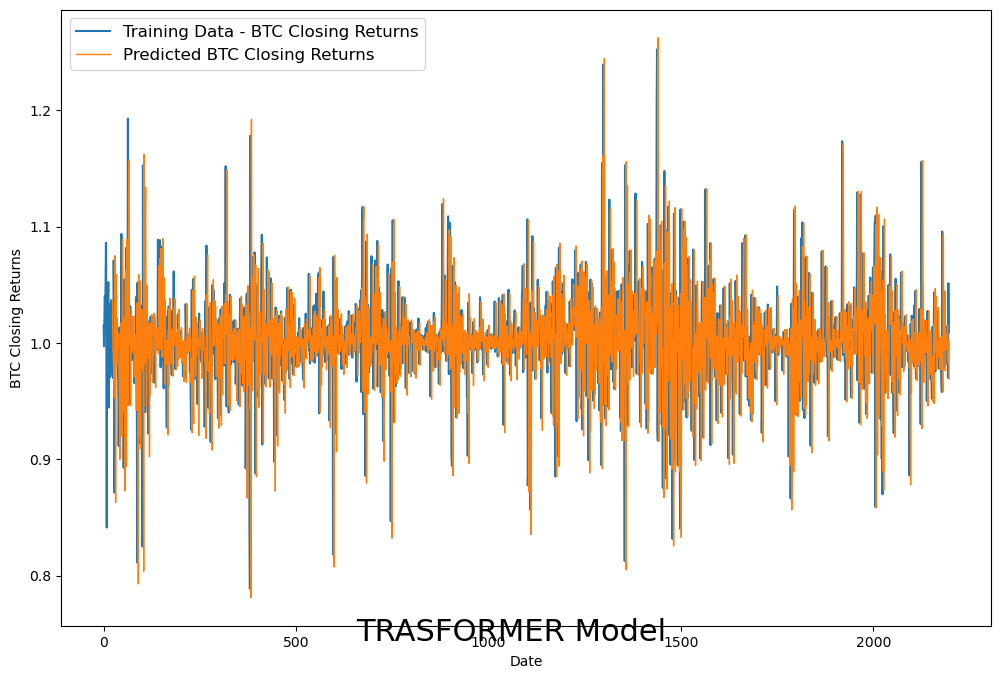

In [73]:
fig = plt.figure(figsize=(12, 8))
st = fig.suptitle("TRASFORMER Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(111)
ax11.plot(xtrain[2:, 0], label='Training Data - BTC Closing Returns')
ax11.plot(np.arange(look_back+2, train_pred.shape[0]+look_back), train_pred[2:,0], linewidth=1, label='Predicted BTC Closing Returns')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

plt.savefig("5_Predicted_Vs_Original_Training_Closing_return_Data.png", dpi = 80)


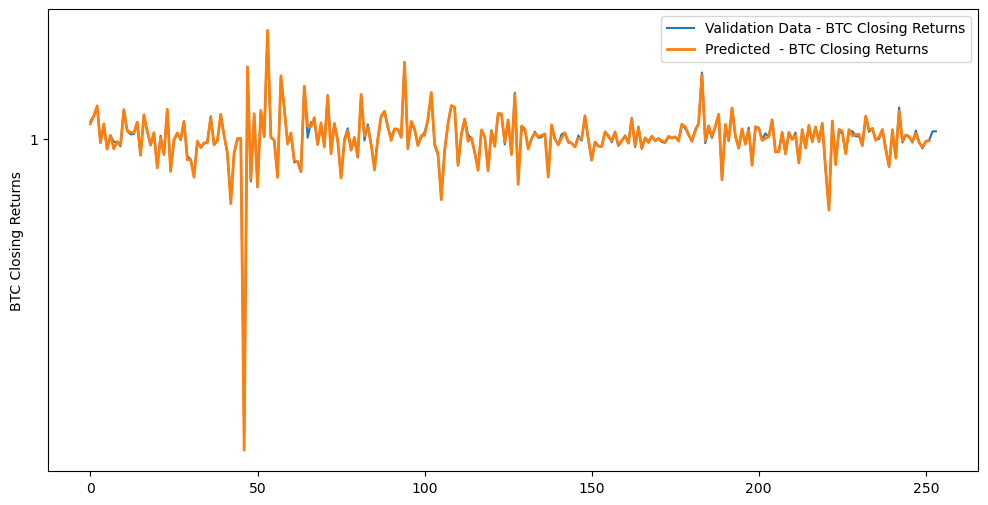

In [74]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xval[21:,0]), label='Validation Data - BTC Closing Returns')
plt.plot(np.log(val_pred[2:,0]), linewidth=2, label='Predicted  - BTC Closing Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Closing Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("5_Predicted_Vs_Original_Validation_Closing_Returns_Data.png", dpi = 80)

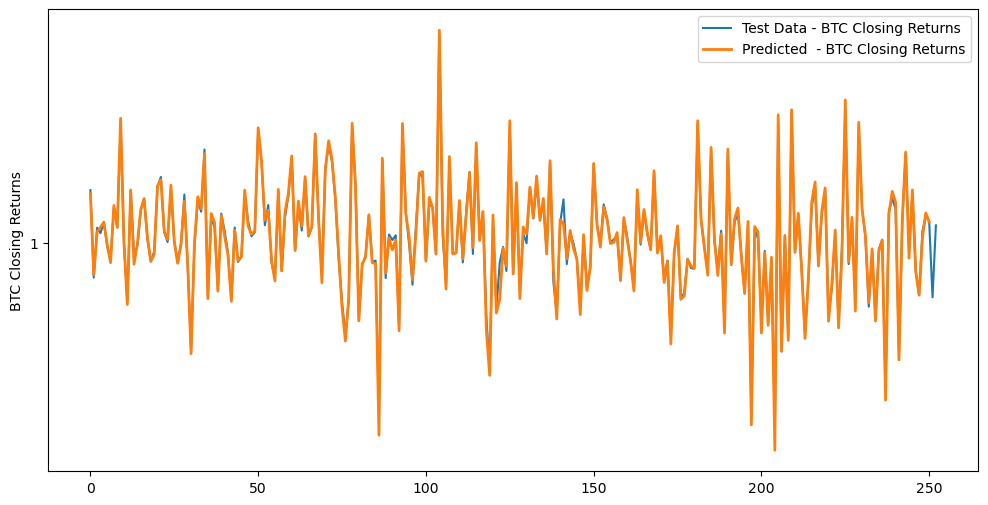

In [75]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xtest[21:,0]), label='Test Data - BTC Closing Returns')
plt.plot(np.log(test_pred[2:,0]), linewidth=2, label='Predicted  - BTC Closing Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Closing Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("5_Predicted_Vs_Original_Test_Closing_Returns_Data.png", dpi = 80)

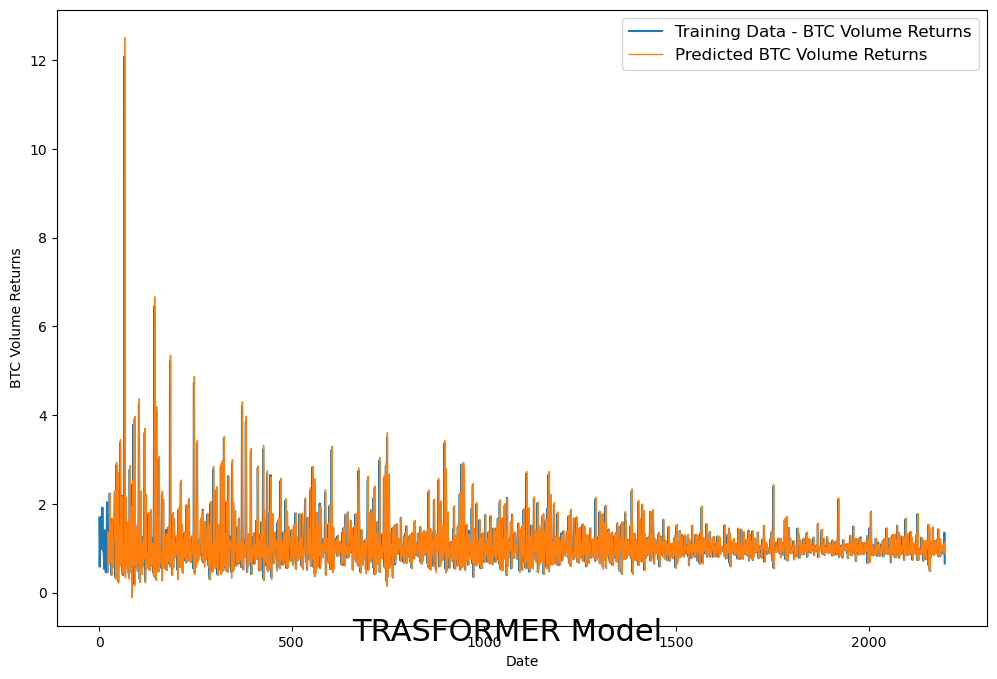

In [76]:
fig = plt.figure(figsize=(12, 8))
st = fig.suptitle("TRASFORMER Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(111)
ax11.plot(xtrain[:, 1], label='Training Data - BTC Volume Returns')
ax11.plot(np.arange(look_back+2, train_pred.shape[0]+look_back), train_pred[2:,1], linewidth=1, label='Predicted BTC Volume Returns')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Volume Returns')
ax11.legend(loc="best", fontsize=12)

plt.show

plt.savefig("5_Predicted_Vs_Original_Training_Volume_return_Data.png", dpi = 80)


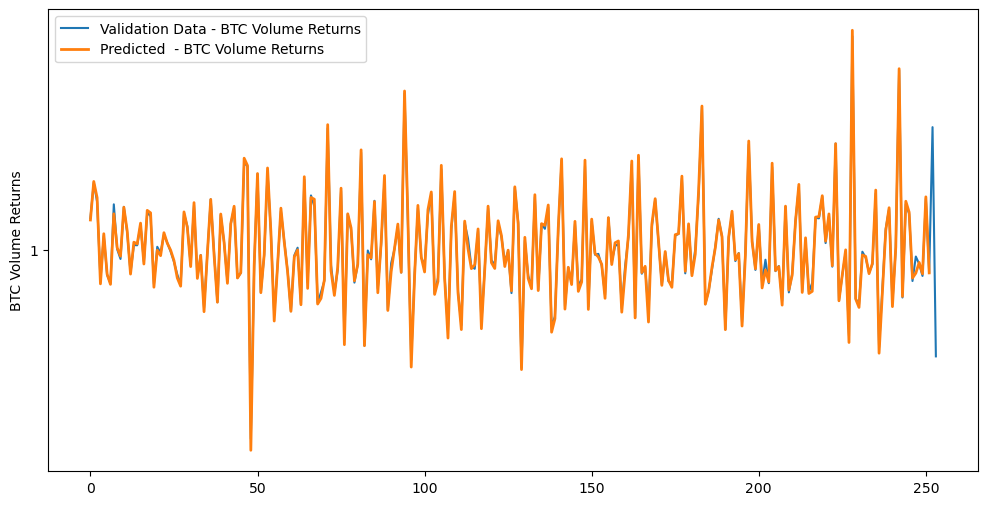

In [77]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xval[21:,1]), label='Validation Data - BTC Volume Returns')
plt.plot(np.log(val_pred[2:,1]), linewidth=2, label='Predicted  - BTC Volume Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Volume Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.show

plt.savefig("5_Predicted_Vs_Original_Validation_Volume_Returns_Data.png", dpi = 80)


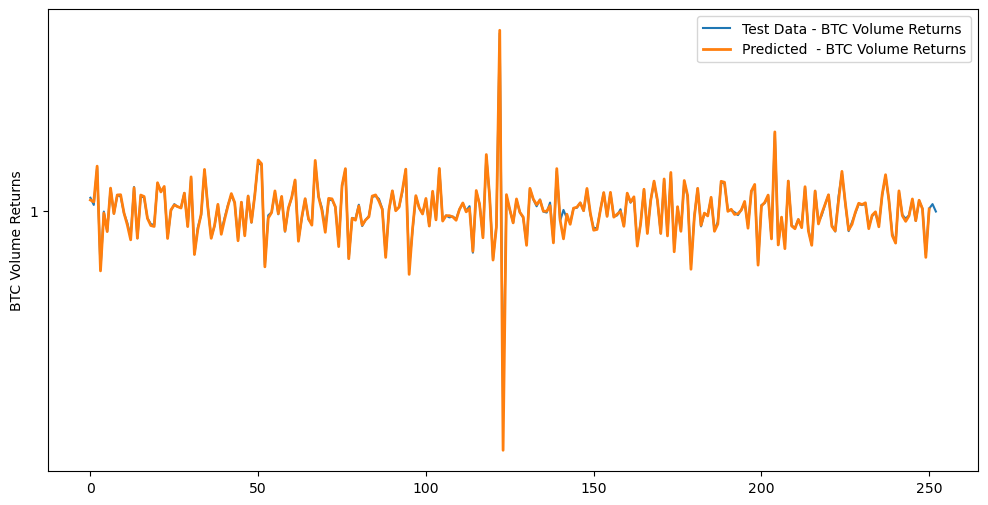

In [78]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xtest[21:,1]), label='Test Data - BTC Volume Returns')
plt.plot(np.log(test_pred[2:,1]), linewidth=2, label='Predicted  - BTC Volume Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Volume Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.show

plt.savefig("5_Predicted_Vs_Original_Test_Volume_Returns_Data.png", dpi = 80)
